# Drifting Gratings
Organizing data by drifting gratings stimulus

Create manifest to keep track of data

In [14]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

Import stim info data

In [15]:
import allensdk.brain_observatory.stimulus_info as stim_info


Import required packages for code

In [16]:
from matplotlib import pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cmath

import pandas as pd

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")


In [17]:
# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens() # this code may be moved outside of the function?
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

total cells: 63251


 FUNCTIONS

In [18]:
# plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
# freq_ind, ori_ind, axs): calculates average dff for a single type of stim. 
#
#
#
#
# freq: temporal frequency of stimulus
# ori: orientation of stimulus
# dsi_cell: NWB file for cell
# data_set:  ophys experiment data
# print_graphs: boolean value, if true, plots all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# ori_ind: indice of orientation axis for subplots
# freq_ind: indice of frequency axis for subplots
# axs: subplot object
def plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
            freq_ind, ori_ind, axs):
    
    # get flourescence traces for target cell
    dsi_cell_id = dsi_cell['cell_specimen_id']
    time, f_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
    
    # this is a pandas DataFrame. find trials with a given stimulus condition.
    # 40 diff total conditions
    temporal_frequency = freq
    orientation = ori
    stim_table = data_set.get_stimulus_table('drifting_gratings')
    stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & 
                            (stim_table.orientation == orientation)]
    
    # plot of instances of stimulus frames
    if (plot_stim_instances) :
        plot_stimulus_table(stim_table, "Instances of Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
        plt.show()
    
    # make 2D array of 120 data points of f_traces and dff_traces for each of the 15 trials
    all_f_traces = [[0]*120 for i in range(15)] 
    dff_traces = [[0]*120 for i in range(15)] 
    x=0
    
    # plot 15 trial graphs
    # initialize trial graph subplots
    if (print_graphs):
        fig_trial, axs_trial = plt.subplots(3, 5, sharey=True, figsize=(10,10))
        fig_trial.suptitle("15 Trials for Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
    x_ind = 0 
    y_ind = 0
    
    for start_ind in stim_table.start:
        
        all_f_traces[x] = f_traces[0][start_ind-30:start_ind+90] # get f_traces at desired indices
        F0 = np.mean(f_traces[0][start_ind-30:start_ind]) # calculate baseline as the preceding second before stim
        dff_traces[x] = (all_f_traces[x]-F0)/F0  # calculate dff at desired indices
        
        if (plot_avg_graph and plot_trial_on_avg) :
            axs[freq_ind, ori_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
        if (print_graphs) :
            axs_trial[x_ind, y_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
            axs_trial[x_ind, y_ind].set_title("Frames %d to %d" % (start_ind-30,start_ind+90),
                                              fontdict = {'fontsize': 7})

            # Mark the area of the stimulus
            axs_trial[x_ind, y_ind].fill_between(time[0:60]-time[0], min(dff_traces[x]), 
                                                                         min(dff_traces[x])+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
            
            for ax in axs_trial.flat:
                ax.set(xlabel='sec', ylabel='dF/F')
            for ax in axs_trial.flat:
                ax.label_outer()

            y_ind +=1 
            if (y_ind > 4) : 
                y_ind = 0
                x_ind +=1
        
        x+=1
    
    # calculate and plot the average response of all graphs
    mean_dff = np.mean(dff_traces, axis=0)
    
    if (plot_avg_graph) :
        axs[freq_ind,ori_ind].plot(time[0:120]-time[0]-1,mean_dff, color='black')
        axs[freq_ind,ori_ind].set_title("TF %d ORI %d" %(temporal_frequency, orientation))
        axs[freq_ind,ori_ind].fill_between(time[0:60]-time[0], 
                min(mean_dff), min(mean_dff)+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
    
    # calculate single value average dff from average graph
    return np.mean(mean_dff[30:90])
    
    

In [19]:
# dg_for_cell(index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, show_text) : given
# a cell index, will calculate and return Rmax, pref TF, pref ORI, Rorth, OSI and gOSI values. Will print 
# metadata, avg response graphs for each kind of stim, and trial graphs if desired. 
# 
#
#
# boc : manifest that keeps track of downloaded data
# dsi_cells: object containing all direction selective cells in given brain region
# index: index of cell in vector of filtered direction selective cells. There are 1159 direction selective cells. 
# Index values can range from 0 to 1158
# plot_trial_graphs: boolean value, if true, shows all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# show_text: boolean value, if true, prints text information such as cell metadata, stimulus matrix,
# and outputs of analysis calculations
# cre_lines_list: if not empty, will filter cells by the given cell types 
#
# Warning- calling this function will require downloading the ophys experiment data, which may take some time
# This function downloads the NWB files that contain the fluorescence traces for segmented cells in 
# those experiments that used the dg stim
def dg_for_cell(boc, dsi_cells, index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
                show_text, cre_lines_list): 
    
    # pick a direction-selective cell and find its NWB file
    dsi_cell = dsi_cells.iloc[index]
    
    # determine and filter by cell type
    cell_type = dsi_cell.tld1_name
    for cre_line in cre_lines_list:
        if (cell_type == cre_line):
            continue
        if (cre_line == cre_lines_list[-1]) : 
            return None
    
    # figure out which ophys experiment has the drifting gratings stimulus for that cell
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])[0]

    data_set = boc.get_ophys_experiment_data(cell_exp['id'])
    
    if (show_text):
        print("Metadata from NWB file:")
        pprint.pprint(data_set.get_metadata())
    
    # initialize stim_matrix
    stim_matrix = [[0]*8 for i in range(5)]
    
    # initialize avg graph subplots
    if (plot_avg_graph) :
        fig, axs = plt.subplots(5, 8, sharey=True, figsize=(15,15))
        fig.suptitle('Average Fluorescence For Each Stim')
        for ax in axs.flat:
            ax.set(xlabel='sec', ylabel='dF/F')
        for ax in axs.flat:
            ax.label_outer()
    else :
        axs = None 
        
    # make avg graph subplots and calculate average dff for each stim
    freq_array = [1,2,4,8,15]
    ori_array = [0,45,90,135,180,225,270,315]
    freq_ind = 0
    for freq in freq_array :
        ori_ind = 0
        for ori in ori_array :
            avg_dff = plot_dg(freq, ori, dsi_cell, data_set, plot_trial_graphs, plot_stim_instances, 
                              plot_avg_graph, plot_trial_on_avg, freq_ind, ori_ind, axs)
            stim_matrix[freq_ind][ori_ind] = avg_dff
            ori_ind +=1
        freq_ind += 1
    
    # print stim_matrix
    row_labels = ['1', '2', '4', '8', '15']
    column_labels = ['0','45','90','135','180','225','270','315']
    if (show_text):
        print(pd.DataFrame(stim_matrix, columns=column_labels, index=row_labels))
    
    # calc R max val in stim_matrix
    Rmax = np.amax(stim_matrix)
    if (show_text): print("Cell has Rmax of %f" % Rmax)
    result = np.where(stim_matrix == np.amax(stim_matrix))
    max_coor = list(zip(result[0], result[1]))
    if (show_text): print("At temporal frequency of %d and orientation of %d" % 
          (freq_array[max_coor[0][0]], ori_array[max_coor[0][1]]))
    
    # calc R orth
    Rorth = (stim_matrix[max_coor[0][0]][max_coor[0][1]-2] + stim_matrix[max_coor[0][0]][(max_coor[0][1]+2)%8])/2
    if (show_text): print("Rorth: %f" % Rorth)
    
    # calc OSI
    OSI = (Rmax - Rorth)/(Rmax + Rorth)
    if (show_text): print("OSI: %f" % OSI)
    
    # calc gOSI
    Rtheta=0
    Rtheta_exp=0
    for i in range(0, 8) :
        Rtheta += stim_matrix[max_coor[0][0]][i]
        Rtheta_exp += (Rtheta * cmath.exp(complex(0,2)*ori_array[i]))
    gOSI = abs(Rtheta_exp/Rtheta)
    if (show_text): print("gOSI: %f" % gOSI)
    
    # find cre_line
    cre_line = cell_exp['cre_line']
    
    # return array of Rmax, pref TF, pref ORI, Rorth, OSI, gOSI values, and cre_line
    return [Rmax, freq_array[max_coor[0][0]], ori_array[max_coor[0][1]], Rorth, OSI, gOSI, cre_line]
    

In [67]:
# create_histogram(): creates histogram of OSI of all cells in desired cortical layer. returns array of OSI values
# 
#
#
#
# targeted_struct: string argument identifying desired cortical layer. Options are
# 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'. Higher order visual cortices (VISam, VISpm, VISrl) show
# decreased activity with increased running speed
# print_OSIs: when set to true, will print the OSIs for each cell
# print_other_vals: when set to true, will print the Rmax, pref TF, pref ORI, Rorth, and gOSI
# filter_vals: when set to true, creates the histogram and excludes OSIs below 0 or above 2
# cre_lines_list: given one or multiple cre_lines, will filter the cells of the targeted structure to those cells
# max_cells: if given a value, will only run a maximum of that amount of cells
# print_histogram: if true will output the histogram plots
#
# Warning: will require downloading nwb files for many cells. Will take a while 
def create_histogram(targeted_struct, print_OSIs, print_other_vals, filter_vals, cre_lines_list, max_cells, 
                    print_histogram):
    
    # Download experiment containers for experiments of target structure
    exp_containers = boc.get_experiment_containers(targeted_structures=[targeted_struct])
    print("all %s experiment containers: %d" % (targeted_struct, len(exp_containers)))
    
    # Download cells for a set of experiments and convert to DataFrame
    #cells = boc.get_cell_specimens() # this code may be moved outside of the function?
    #cells = pd.DataFrame.from_records(cells)
    #print("total cells: %d" % len(cells))

    # find direction selective cells in target_struct
    exp_container_ids = [ ec['id'] for ec in exp_containers ]
    structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
    print("%s cells: %d" % (targeted_struct, len(structure_cells)))

    # significant response to drifting gratings stimulus
    sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
    print("cells with sig. response to drifting gratings: %d" % len(sig_cells))
    
    dsi_cells = sig_cells

    # direction selective cells
    #dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.75)]  #lower threshold or get rid of entirely?
    #print("direction-selective cells: %d" % len(dsi_cells))

    OSIs = []
    OSI_index=0
    index = 0
    
    if (max_cells != None) : # decide max cells desired in histogram 
        max_runs = max_cells
    else : 
        max_runs = len(dsi_cells)

    while (OSI_index < max_runs) and (index < len(dsi_cells)):
        cell_vals = dg_for_cell(boc, dsi_cells, index, False, False, False, False, False, cre_lines_list)
        if (cell_vals != None) :
            OSI = cell_vals[4] ### CHANGE INDEX TO CHANGE FILTERING ON OSI vs gOSI DATA TYPE ###
            if(filter_vals) :
                if(0 <= OSI <= 2):
                    OSIs.append(cell_vals)
                    if (print_OSIs) : print(OSI_index, "Cell", index, "OSI:", OSI)
                    if (print_other_vals) : 
                        print("Rmax:", cell_vals[0])
                        print("Pref TF:", cell_vals[1])
                        print("Pref ORI:", cell_vals[2])
                        print("Rorth:", cell_vals[3])
                        print("gOSI:", cell_vals[5])
                    OSI_index += 1
            else : 
                OSIs.append(cell_vals)
                if (print_OSIs) : print(OSI_index, "Cell", index, "OSI:", OSI)
                if (print_other_vals) : 
                    print("Rmax:", cell_vals[0])
                    print("Pref TF:", cell_vals[1])
                    print("Pref ORI:", cell_vals[2])
                    print("Rorth:", cell_vals[3])
                    print("gOSI:", cell_vals[5])
                OSI_index += 1
        index += 1
    
    if not OSIs : # if OSIs is empty
        print("0 OSI values collected")
    
    if print_histogram:
        plt.hist(list(OSIs), 50, density = 1)
    
    if (filter_vals): plt.title("Distribution of OSI values for %s cells in %s (after filtering)" % 
                               (cre_lines_list, targeted_struct))
    else : plt.title("Distribution of OSI values for %s cells in %s (prior to filtering)" % 
                     (cre_lines_list, targeted_struct))
    plt.xlabel('Orientation Selectivity Index for Drifting Gratings')
    plt.ylabel('Number of Cells')
    
    return OSIs

TESTS

In [8]:
# see all options for cre_lines
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


all VISp experiment containers: 216
VISp cells: 22641
cells with sig. response to drifting gratings: 13401
0 Cell 11171 OSI: 0.8339579386517486
1 Cell 11172 OSI: 0.7163767638419521
2 Cell 11173 OSI: 0.9892507102398824
3 Cell 11174 OSI: 0.6847993661039065
4 Cell 11175 OSI: 0.5855543355021487
5 Cell 11176 OSI: 0.6673666222863881
6 Cell 11177 OSI: 0.927459045237008
7 Cell 11178 OSI: 0.7570512540102375
8 Cell 11179 OSI: 0.8620661019469343
9 Cell 11180 OSI: 0.8408413951842275
10 Cell 11259 OSI: 0.7730811996715533
11 Cell 11260 OSI: 0.5297857440993081
12 Cell 11261 OSI: 0.7421879167899501
13 Cell 11262 OSI: 0.7303921345207186
14 Cell 11263 OSI: 0.7311731497825726
15 Cell 11264 OSI: 0.7284109708633038
16 Cell 11265 OSI: 0.637542650775825
17 Cell 11266 OSI: 0.7222244173602074
18 Cell 11267 OSI: 0.6964753328063082
19 Cell 11268 OSI: 0.6432606615657422
20 Cell 11269 OSI: 0.5866210937312207
21 Cell 11270 OSI: 0.6515660079604738
22 Cell 11271 OSI: 0.5754771355083411
23 Cell 11272 OSI: 0.6906650406

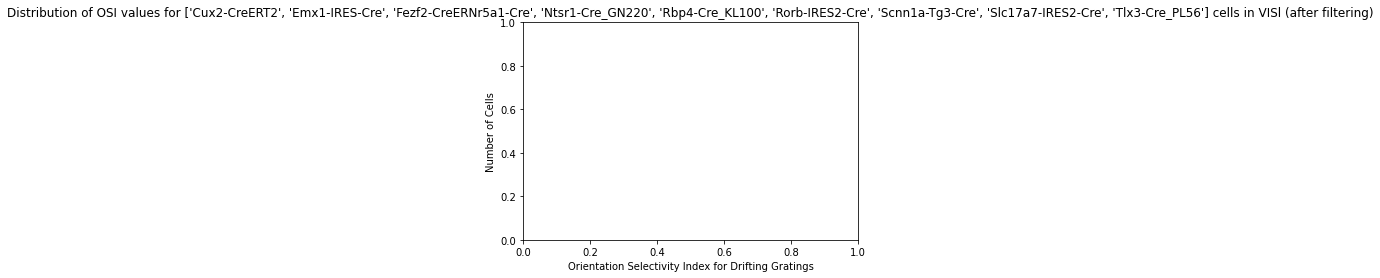

In [21]:
visp_pv = create_histogram('VISp', True, False, True, ['Pvalb-IRES-Cre'], 100, False)
visp_sst = create_histogram('VISp', False, False, True, ['Sst-IRES-Cre'], 100, False)
visp_vip = create_histogram('VISp', False, False, True, ['Vip-IRES-Cre'], 100, False)
visp_exc = create_histogram('VISp', False, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER'
                                                        'Nr5a1-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100',
                                                        'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                                        'Tlx3-Cre_PL56'], 100, False)


visl_pv = create_histogram('VISl', False, False, True, ['Pvalb-IRES-Cre'], 100, False)
visl_sst = create_histogram('VISl', False, False, True, ['Sst-IRES-Cre'], 100, False)
visl_vip = create_histogram('VISl', False, False, True, ['Vip-IRES-Cre'], 100, False)
visl_exc = create_histogram('VISl', False, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER'
                                                        'Nr5a1-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100',
                                                        'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                                        'Tlx3-Cre_PL56'], 100, False)


Cell Comparison

<function matplotlib.pyplot.show(close=None, block=None)>

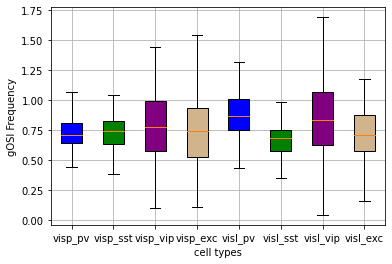

In [49]:
# VISp VISl Comparison

i = 5 ## Choose index of desired data value 0: Rmax, 1: pref TF, 2: pref ORI, 3: Rorth, 4: OSI, 5: gOSI values, 6: cre_line
all_data = [visp_pv, visp_sst, visp_vip, visp_exc, visl_pv, visl_sst, visl_vip, visl_exc]
boxplot_data = []
x=0

for area in all_data:
    boxplot_data.append([row[i] for row in area])
    x += 1

box = plt.boxplot(boxplot_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['visp_pv','visp_sst', 'visp_vip', 'visp_exc', 'visl_pv', 'visl_sst', 'visl_vip', 
                             'visl_exc'], # will be used to label x-ticks 
            sym='') # show outliers 

plt.grid(True)

plt.xlabel('cell types')
plt.ylabel('gOSI Frequency')

 
colors = ['blue', 'green', 'purple', 'tan', 'blue', 'green', 'purple', 'tan']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show





all VISal experiment containers: 41
VISal cells: 7191
cells with sig. response to drifting gratings: 3517
0 OSI values collected
all VISal experiment containers: 41
VISal cells: 7191
cells with sig. response to drifting gratings: 3517
all VISal experiment containers: 41
VISal cells: 7191
cells with sig. response to drifting gratings: 3517
0 OSI values collected
all VISal experiment containers: 41
VISal cells: 7191
cells with sig. response to drifting gratings: 3517
0 OSI values collected


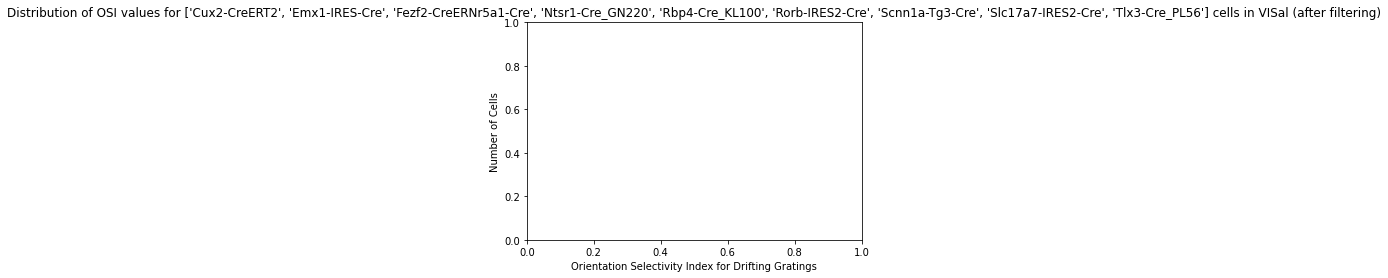

In [58]:
# VISal
visal_pv = create_histogram('VISal', False, False, True, ['Pvalb-IRES-Cre'], 100, False)
visal_sst = create_histogram('VISal', False, False, True, ['Sst-IRES-Cre'], 100, False)
visal_vip = create_histogram('VISal', False, False, True, ['Vip-IRES-Cre'], 100, False)
visal_exc = create_histogram('VISal', False, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER'
                                                        'Nr5a1-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100',
                                                        'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                                        'Tlx3-Cre_PL56'], 100, False)



<function matplotlib.pyplot.show(close=None, block=None)>

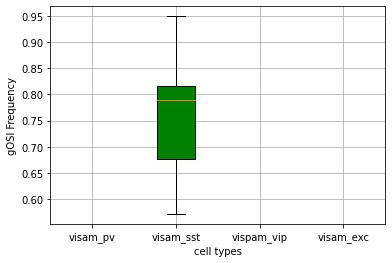

In [59]:
i = 5 ## Choose index of desired data value 0: Rmax, 1: pref TF, 2: pref ORI, 3: Rorth, 4: OSI, 5: gOSI values, 6: cre_line
all_data = [visal_pv, visal_sst, visal_vip, visal_exc]
boxplot_data = []
x=0

for area in all_data:
    boxplot_data.append([row[i] for row in area])
    x += 1

box = plt.boxplot(boxplot_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['visam_pv','visam_sst', 'vispam_vip', 'visam_exc'], # will be used to label x-ticks 
            sym='') # show outliers 

plt.grid(True)

plt.xlabel('cell types')
plt.ylabel('gOSI Frequency')

 
colors = ['blue', 'green', 'purple', 'tan']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show

all VISpm experiment containers: 87
VISpm cells: 7985
cells with sig. response to drifting gratings: 3220
0 OSI values collected
all VISpm experiment containers: 87
VISpm cells: 7985
cells with sig. response to drifting gratings: 3220
all VISpm experiment containers: 87
VISpm cells: 7985
cells with sig. response to drifting gratings: 3220


2022-08-10 18:22:12,454 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/609779562
2022-08-10 18:24:41,614 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/643114702
2022-08-10 18:25:28,656 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/653008622
2022-08-10 18:28:38,542 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/649332540
2022-08-10 18:57:47,884 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/648187929
2022-08-10 19:00:53,012 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650079447
2022-08-10 19:05:13,060 allensdk.api.api.retrieve_fi

all VISpm experiment containers: 87
VISpm cells: 7985
cells with sig. response to drifting gratings: 3220
0 OSI values collected


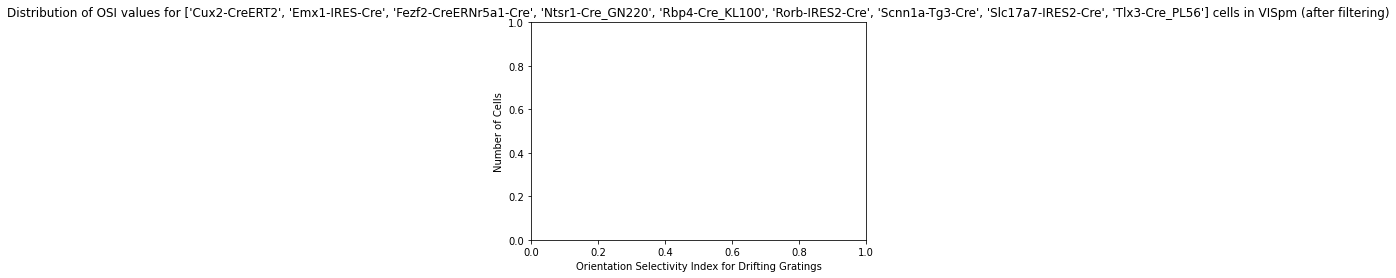

In [63]:
# VISpm

vispm_pv = create_histogram('VISpm', False, False, True, ['Pvalb-IRES-Cre'], 100, False)
vispm_sst = create_histogram('VISpm', False, False, True, ['Sst-IRES-Cre'], 100, False)
vispm_vip = create_histogram('VISpm', False, False, True, ['Vip-IRES-Cre'], 100, False)
vispm_exc = create_histogram('VISpm', False, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER'
                                                        'Nr5a1-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100',
                                                        'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                                        'Tlx3-Cre_PL56'], 100, False)



<function matplotlib.pyplot.show(close=None, block=None)>

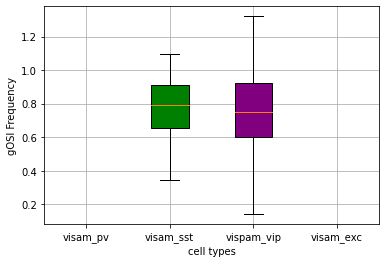

In [65]:
i = 5 ## Choose index of desired data value 0: Rmax, 1: pref TF, 2: pref ORI, 3: Rorth, 4: OSI, 5: gOSI values, 6: cre_line
all_data = [vispm_pv, vispm_sst, vispm_vip, vispm_exc]
boxplot_data = []


for area in all_data:
    boxplot_data.append([row[i] for row in area])


box = plt.boxplot(boxplot_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['visam_pv','visam_sst', 'vispam_vip', 'visam_exc'], # will be used to label x-ticks 
            sym='') # do not show outliers 

plt.grid(True)

plt.xlabel('cell types')
plt.ylabel('gOSI Frequency')

 
colors = ['blue', 'green', 'purple', 'tan']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show

all VISrl experiment containers: 40
VISrl cells: 8247
cells with sig. response to drifting gratings: 1271
0 OSI values collected
all VISrl experiment containers: 40
VISrl cells: 8247
cells with sig. response to drifting gratings: 1271
all VISrl experiment containers: 40
VISrl cells: 8247
cells with sig. response to drifting gratings: 1271
0 OSI values collected
all VISrl experiment containers: 40
VISrl cells: 8247
cells with sig. response to drifting gratings: 1271
0 OSI values collected


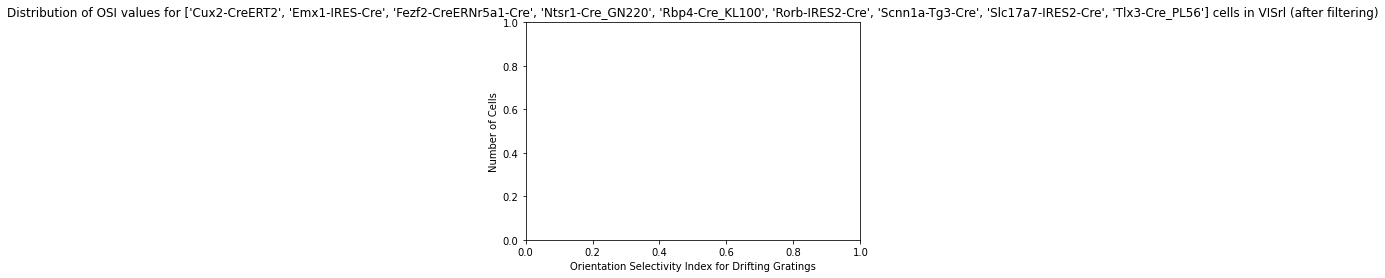

In [69]:
# VISrl

visrl_pv = create_histogram('VISrl', False, False, True, ['Pvalb-IRES-Cre'], 100, False)
visrl_sst = create_histogram('VISrl', False, False, True, ['Sst-IRES-Cre'], 100, False)
visrl_vip = create_histogram('VISrl', False, False, True, ['Vip-IRES-Cre'], 100, False)
visrl_exc = create_histogram('VISrl', False, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER'
                                                        'Nr5a1-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100',
                                                        'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                                        'Tlx3-Cre_PL56'], 100, False)


<function matplotlib.pyplot.show(close=None, block=None)>

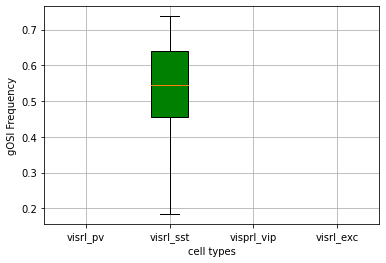

In [72]:
i = 4 ## Choose index of desired data value 0: Rmax, 1: pref TF, 2: pref ORI, 3: Rorth, 4: OSI, 5: gOSI values, 6: cre_line
all_data = [visrl_pv, visrl_sst, visrl_vip, visrl_exc]
boxplot_data = []


for area in all_data:
    boxplot_data.append([row[i] for row in area])


box = plt.boxplot(boxplot_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['visrl_pv','visrl_sst', 'visprl_vip', 'visrl_exc'], # will be used to label x-ticks 
            sym='') # do not show outliers 

plt.grid(True)

plt.xlabel('cell types')
plt.ylabel('gOSI Frequency')

 
colors = ['blue', 'green', 'purple', 'tan']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show

Run to see data analysis done by the Allen Institute (peak response, OSI, gOSI, etc.) 

In [ ]:
dsi_cell = dsi_cells.iloc[15]
print("Peak dff: Allen %0.3f" % dsi_cell.peak_dff_dg, "vs. est %0.3f" % (cellInfo[0]*100))
print("Pref dir: Allen %0.f" % dsi_cell.pref_dir_dg, "vs. est %0.f" % cellInfo[2])
print("Pref tf: Allen %0.f" % dsi_cell.pref_tf_dg, "vs. est %0.f" % cellInfo[1])
print("OSI: Allen %.2f" % dsi_cell.osi_dg, "vs. est %.2f" % cellInfo[4])